### Volume Bars 

Construir volume bars a partir de las time bars (1 min) cada volume bar debe abrupar filas sucesivas hasta que la suma de volume alcance o supere un umbral V_threshold.

Resultados esperados: 
- Data frame con filas por volume bar con columnas 
- Comparativa (número de barras por día, distribución de retornos, test de normalidad/autocorrelación) 
- Guardar el resultado en data/processed/volume_bars_<Vthreshold>.csv

In [55]:
# imports 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
# timestamp 
import time

In [56]:
# load data from /data/processed
data = pd.read_csv('../data/processed/BTCUSDT_1m_2024-12-01_to_2025-01-01_cleaned_robust.csv')
data.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,trades,taker_buy_base,taker_buy_quote,ignore,mid_price,return
0,2024-12-01 05:01:00,96473.19,96473.19,96464.16,96464.97,2.51941,2024-12-01 05:01:59.999,2.430386e+05,1044.0,0.82286,79377.044051,0.0,96468.675,-0.000085
1,2024-12-01 05:02:00,96464.97,96509.99,96425.70,96509.99,40.57111,2024-12-01 05:02:59.999,3.913119e+06,4030.0,9.65762,931709.380920,0.0,96467.845,0.000467
2,2024-12-01 05:03:00,96509.99,96510.00,96476.00,96480.00,6.33996,2024-12-01 05:03:59.999,6.118070e+05,2520.0,0.81025,78177.723577,0.0,96493.000,-0.000311
3,2024-12-01 05:04:00,96480.01,96480.01,96472.00,96472.00,2.02027,2024-12-01 05:04:59.999,1.949119e+05,603.0,0.10671,10295.342507,0.0,96476.005,-0.000083
4,2024-12-01 05:05:00,96472.00,96472.01,96415.65,96420.02,8.16665,2024-12-01 05:05:59.999,7.875664e+05,2192.0,0.70645,68130.564183,0.0,96443.830,-0.000539


In [57]:
# ---------- CELDA: conversión robusta de timestamps ----------
import pandas as pd
import numpy as np

# 1) Inspección rápida de la columna
print("dtype original:", data['open_time'].dtype)
print("primeros 10 valores (raw):")
display(data['open_time'].head(10))

# 2) Normalizar strings: strip y reemplazos comunes
# (solo si la columna es de tipo object)
if data['open_time'].dtype == object:
    # eliminar espacios, comillas, saltos de línea
    data['open_time'] = data['open_time'].astype(str).str.strip().str.replace('"', '', regex=False).str.replace("'", "", regex=False)
    data['close_time'] = data['close_time'].astype(str).str.strip().str.replace('"', '', regex=False).str.replace("'", "", regex=False)

# 3) Detectar si la columna es numérica codificada como strings (solo dígitos)
sample_vals = data['open_time'].dropna().astype(str).head(50)
n_digit_samples = sample_vals.apply(lambda x: x.isdigit()).sum()
print(f"de los primeros 50 valores, {n_digit_samples} parecen solo dígitos (epoch)")

# 4) Función que intenta convertir robustamente cada valor (vectorizada)
def robust_to_datetime(series):
    # si ya es datetime, devolver
    if np.issubdtype(series.dtype, np.datetime64):
        return series
    
    s = series.copy()
    # 4a) Si todos (o mayoría) son dígitos -> intentar como epoch ms o s
    as_str = s.dropna().astype(str)
    is_all_digits = as_str.str.match(r'^\d+$').mean()  # proporción de strings sólo dígitos
    
    if is_all_digits > 0.5:
        # la mayoría son timestamps numéricos; inferir ms vs s por magnitud
        # convertir a float para inspección del tamaño (usa sample para evitar overflow)
        sample_num = as_str.sample(min(100, len(as_str))).astype(float)
        median_sample = sample_num.median()
        print("mediana de muestra numérica:", median_sample)
        if median_sample > 1e12:  # típico de ms epoch ( > ~10^12)
            print("-> inferido como epoch en MILLISEGUNDOS")
            out = pd.to_datetime(s.astype(float), unit='ms', errors='coerce')
        elif median_sample > 1e9:  # típico de s epoch ( > ~10^9)
            print("-> inferido como epoch en SEGUNDOS")
            out = pd.to_datetime(s.astype(float), unit='s', errors='coerce')
        else:
            # números pequeños: tratar como strings normalmente
            out = pd.to_datetime(s, errors='coerce')
        return out
    else:
        # 4b) hay muchos strings legibles - intentar parse directo
        # algunos formatos con milisegundos tienen punto decimal: '2024-12-01 05:00:59.999'
        # pd.to_datetime normalmente lo maneja. Usamos errors='coerce' y luego mostraremos fallos.
        out = pd.to_datetime(s, errors='coerce', utc=False)
        # si demasiados NaT, intentar forzar formatos comunes
        nat_frac = out.isna().mean()
        print(f"frac NaT tras parse directo: {nat_frac:.3f}")
        if nat_frac > 0.2:
            # intentar parse con varias plantillas comunes
            fmts = [
                "%Y-%m-%d %H:%M:%S.%f",
                "%Y-%m-%d %H:%M:%S",
                "%Y-%m-%dT%H:%M:%S.%fZ",
                "%Y-%m-%dT%H:%M:%SZ",
            ]
            for fmt in fmts:
                try:
                    test = pd.to_datetime(s, format=fmt, errors='coerce')
                    nat_frac2 = test.isna().mean()
                    print(f"  intento con format {fmt} => NaT frac: {nat_frac2:.3f}")
                    if nat_frac2 < nat_frac:
                        out = test
                        nat_frac = nat_frac2
                except Exception:
                    pass
        return out

# Aplicar la función a open_time y close_time
data['open_time_parsed'] = robust_to_datetime(data['open_time'])
data['close_time_parsed'] = robust_to_datetime(data['close_time'])

# 5) Informar resultados y mostrar ejemplos problemáticos
n_total = len(data)
n_nat_open = data['open_time_parsed'].isna().sum()
n_nat_close = data['close_time_parsed'].isna().sum()
print(f"open_time -> NaT: {n_nat_open}/{n_total} ({n_nat_open/n_total:.3%})")
print(f"close_time -> NaT: {n_nat_close}/{n_total} ({n_nat_close/n_total:.3%})")

if n_nat_open > 0:
    print("Ejemplos de open_time problemáticos:")
    display(data.loc[data['open_time_parsed'].isna(), 'open_time'].head(10))

# 6) Reemplazar columnas originales solo si conversión OK en la mayoría
if (n_nat_open / n_total) < 0.05:
    data['open_time'] = data['open_time_parsed']
else:
    print("Advertencia: demasiados NaT en open_time — revisa los ejemplos anteriores.")
    # no sobrescribimos para evitar pérdida de info

if (n_nat_close / n_total) < 0.05:
    data['close_time'] = data['close_time_parsed']

# borrar columnas auxiliares
data = data.drop(columns=[c for c in ['open_time_parsed', 'close_time_parsed'] if c in data.columns])

# 7) Eliminar filas con open_time NaT si quieres (opcional)
data = data.dropna(subset=['open_time'])

print("Conversión final: dtype open_time =>", data['open_time'].dtype)
display(data.head())


dtype original: object
primeros 10 valores (raw):


0    2024-12-01 05:01:00
1    2024-12-01 05:02:00
2    2024-12-01 05:03:00
3    2024-12-01 05:04:00
4    2024-12-01 05:05:00
5    2024-12-01 05:06:00
6    2024-12-01 05:07:00
7    2024-12-01 05:08:00
8    2024-12-01 05:09:00
9    2024-12-01 05:10:00
Name: open_time, dtype: object

de los primeros 50 valores, 0 parecen solo dígitos (epoch)
frac NaT tras parse directo: 0.000
frac NaT tras parse directo: 0.000
open_time -> NaT: 0/43138 (0.000%)
close_time -> NaT: 0/43138 (0.000%)
Conversión final: dtype open_time => datetime64[ns]


,open_time,open,high,low,close,volume,close_time,quote_volume,trades,taker_buy_base,taker_buy_quote,ignore,mid_price,return
0,2024-12-01 05:01:00,96473.19,96473.19,96464.16,96464.97,2.51941,2024-12-01 05:01:59.999,2.430386e+05,1044.0,0.82286,79377.044051,0.0,96468.675,-0.000085
1,2024-12-01 05:02:00,96464.97,96509.99,96425.70,96509.99,40.57111,2024-12-01 05:02:59.999,3.913119e+06,4030.0,9.65762,931709.380920,0.0,96467.845,0.000467
2,2024-12-01 05:03:00,96509.99,96510.00,96476.00,96480.00,6.33996,2024-12-01 05:03:59.999,6.118070e+05,2520.0,0.81025,78177.723577,0.0,96493.000,-0.000311
3,2024-12-01 05:04:00,96480.01,96480.01,96472.00,96472.00,2.02027,2024-12-01 05:04:59.999,1.949119e+05,603.0,0.10671,10295.342507,0.0,96476.005,-0.000083
4,2024-12-01 05:05:00,96472.00,96472.01,96415.65,96420.02,8.16665,2024-12-01 05:05:59.999,7.875664e+05,2192.0,0.70645,68130.564183,0.0,96443.830,-0.000539


In [58]:
# calculate features for v_thereshold bars

# calculete mean volume per minute 

avg_volume = data['volume'].mean()

# calculate mean valume per day
median_day_volume = data.groupby(data['open_time'].dt.date)['volume'].sum().median()

target_bars_per_day = 300

# estimate v_threshold

v_threshold = (median_day_volume / target_bars_per_day + avg_volume * 10) / 2
print("Estimated v_threshold:", v_threshold)

Estimated v_threshold: 139.56935158208657


In [59]:
# def volume bars 

def build_volume_bars(df, v_threshold):
    bars = [] 
    cum_volume = 0

    open_price = None
    high_price = -np.inf
    low_price = np.inf
    volume_acc = 0
    open_time = None

    for i, rw in df.iterrows():
        vol = rw['volume']
        price_open = rw['open']
        price_close = rw['close']
        price_high = rw['high']
        price_low = rw['low']
        time = rw['open_time']
        close_time = rw['close_time']

        # initialize new bar if is needed
        if open_price is None:
            open_price = price_open
            open_time = time 

        # acumulate volum and ranges 
        cum_volume += vol
        volume_acc += vol
        high_price = max(high_price, price_high)
        low_price = min(low_price, price_low)

        # if already reach threshold, close bar
        if cum_volume >= v_threshold:
            bar = {
                'open_time': open_time,
                'open': open_price,
                'high': high_price,
                'low': low_price,
                'close': price_close,
                'volume': volume_acc,
                'close_time': close_time
            }
            bars.append(bar)
            # reset for next bar
            cum_volume = 0
            open_price = None
            high_price = -np.inf
            low_price = np.inf
            volume_acc = 0
        
    bars_df = pd.DataFrame(bars)
    return bars_df

In [60]:
# build volume bars 
v_bars = build_volume_bars(data, v_threshold)
print("num of volume bars:", len(v_bars))
display(v_bars.head())  

num of volume bars: 5286


,open_time,open,high,low,close,volume,close_time
0,2024-12-01 05:01:00,96473.19,96510.00,96385.47,96417.05,154.01150,2024-12-01 05:23:59.999
1,2024-12-01 05:24:00,96417.04,96468.66,96355.00,96400.00,142.63492,2024-12-01 05:53:59.999
2,2024-12-01 05:54:00,96400.00,96483.98,96284.51,96388.01,141.12160,2024-12-01 06:20:59.999
3,2024-12-01 06:21:00,96388.01,96464.00,96341.88,96355.00,145.17075,2024-12-01 06:50:59.999
4,2024-12-01 06:51:00,96355.00,96459.77,96299.10,96449.48,141.15671,2024-12-01 07:23:59.999


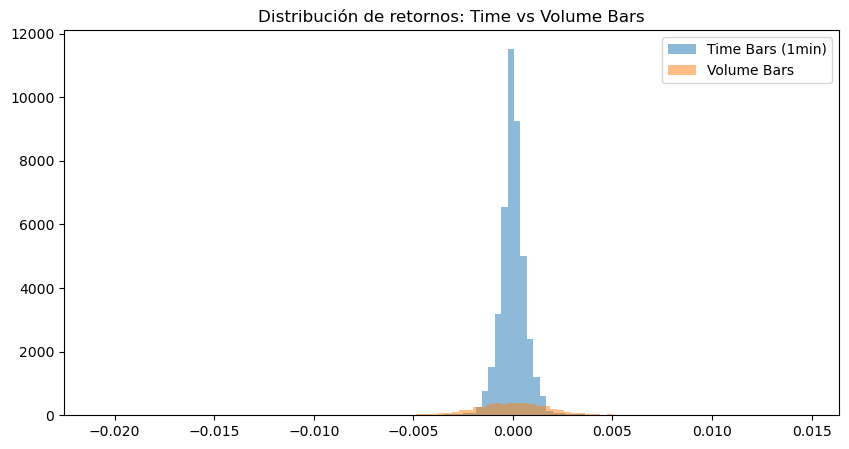

In [61]:
v_bars['return'] = v_bars['close'].pct_change()
data['return'] = data['close'].pct_change()

plt.figure(figsize=(10,5))
plt.hist(data['return'].dropna(), bins=100, alpha=0.5, label='Time Bars (1min)')
plt.hist(v_bars['return'].dropna(), bins=100, alpha=0.5, label='Volume Bars')
plt.legend()
plt.title("Distribución de retornos: Time vs Volume Bars")
plt.show()


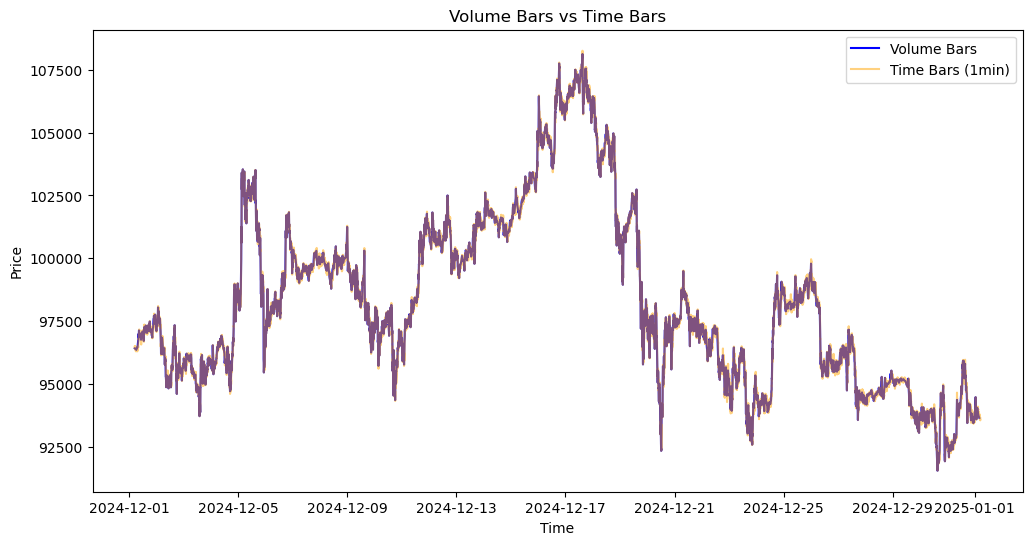

In [62]:
# plot volume bars 
plt.figure(figsize=(12,6))
plt.plot(v_bars['open_time'], v_bars['close'], label='Volume Bars', color='blue')
plt.plot(data['open_time'], data['close'], label='Time Bars (1min)', color='orange', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Volume Bars vs Time Bars')
plt.legend()
plt.show()

In [63]:
# save standard data in csv /processed
v_bars.dropna()
v_bars.to_csv('../data/processed/BTCUSDT_1m_2024-12-01_to_2025-01-volume.csv', index=False)